# **Experiment #2 - Model Training (Step By Step)**

This notebook demonstrates the key processing steps of the Launder Monitoring software.

<br>

**Step 1. Load the external dependencies.**

In [1]:
# import standard modules
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import matplotlib.pyplot as plt

# keras modules for creating and training LSTM Model
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import keras

from sklearn.preprocessing import MinMaxScaler #consider StandardScaler?
from pickle import dump # from saving the scaler to file

<br>

**Step 2. Load the training and test data.**

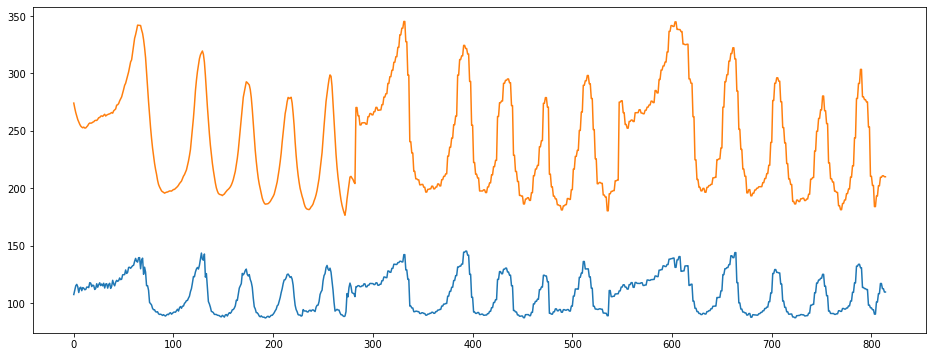

In [2]:
df = pd.read_csv('DATA/merged_output_3.csv', usecols=["Brightness", "Temperature"]) #specify colums to read
#df = pd.read_csv('DATA/merged_output_3.csv') #all columns

bright = df["Brightness"]
temp = df["Temperature"]

# show the data
plt.figure(figsize=(16, 6))
plt.plot(bright)
plt.plot(temp)
plt.show()

<br>

**Step 3. Scale the data.**

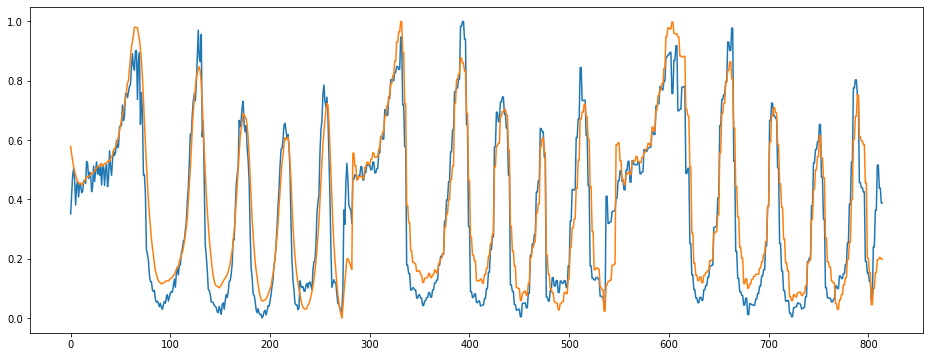

In [3]:
#scale the data
scaler = MinMaxScaler()
scaler = scaler.fit(df)
scaled_df = scaler.transform(df)

# save the scaler
dump(scaler, open('scaler.pkl', 'wb'))

#create lists for each metric
scaled_bright = [d[0] for d in scaled_df]
scaled_temp = [d[1] for d in scaled_df]

#convert lists back to numpy array
scaled_bright = np.array(scaled_bright)
scaled_temp = np.array(scaled_temp)

# show the scaled data
plt.figure(figsize=(16, 6))
plt.plot(scaled_bright)
plt.plot(scaled_temp)
plt.show()

<br>

**Step 4. Reshape the data to a format that keras can work with.**

In [4]:
# reshape the data to a format that keras can work with
scaled_bright = scaled_bright.reshape((len(bright), 1))
scaled_temp = scaled_temp.reshape((len(temp), 1))

# horizontally stack columns
dataset = hstack((scaled_bright, scaled_temp))

# split the test and train data
ds_split = int(len(dataset) *.8)
train_dataset = dataset[:ds_split] #first 80%
test_dataset = dataset[ds_split:] #last 20% 
#print(len(test_dataset)) - 163

<br>

**Step 5. Define the generator.**

In [5]:
# define generator
n_features = dataset.shape[1] #2; because we have 2 datasets - temp and brightness
n_input = 20 #2 because of 2 sequential points (will be more in my final version)
#generator = TimeseriesGenerator(train, dataset, length=n_input, batch_size=8)
generator_train = TimeseriesGenerator(train_dataset, train_dataset, length=n_input, batch_size=8)
generator_test = TimeseriesGenerator(test_dataset, test_dataset, length=n_input, batch_size=8)

<br>

**Step 6. Define and fit the model.**

In [13]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')

# fit model

# https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/
# https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

#model.fit_generator(generator, steps_per_epoch=1, epochs=500, verbose=0) #verbose 0 (silent); 1 (progress bar); 2 (one line per epoch)
model.fit_generator(
    generator = generator_train, 
    steps_per_epoch = 10, 
    epochs = 100, 
    verbose = 0,
    validation_data = generator_test
    
) #verbose 0 (silent); 1 (progress bar); 2 (one line per epoch)

C:\Users\Mike\OneDrive\Desktop\Final_Code\env_submit\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


<br>

**Step 7. Visualize loss over training epochs.**

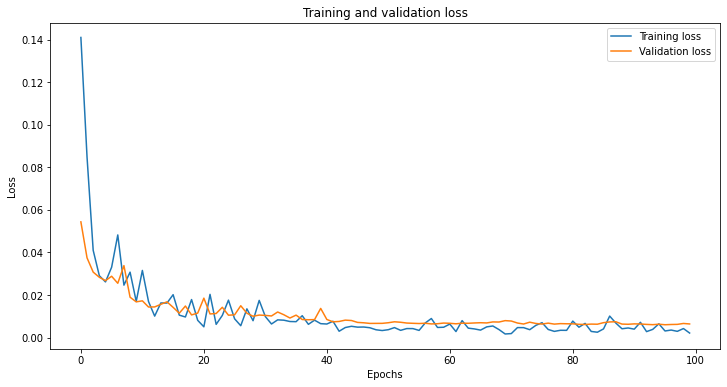

In [14]:
# visualize loss over training epochs
plt.figure(figsize=(12, 6))
plt.plot(model.history.history['loss'], label='Training loss')
plt.plot(model.history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<br>

**Step 8. Test Predictions.**

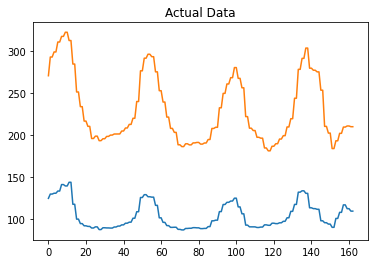

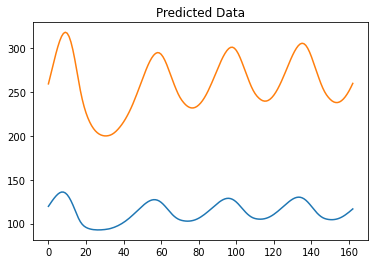

In [15]:
test_predictions = []

#last 100 records of TRAINING dataset
first_eval_batch = train_dataset[-n_input:] 
#print(first_eval_batch)
current_batch = first_eval_batch.reshape((1, n_input, n_features))

# #length of test = 12
# #test is the original test dataframe; not scaled
#print(len(test_dataset)) - 163
for i in range(len(test_dataset)):
    
    # GET THE PREDICTION VALUE FOR first month
    current_pred = model.predict(current_batch)[0]
    #print(current_pred)
    
    # append the prediction into the array
    test_predictions.append(current_pred)
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
#perform inverse scaling to arrive at actual prediction
true_predictions = scaler.inverse_transform(test_predictions)
true_production = scaler.inverse_transform(test_dataset)
plt.plot(true_production)
plt.title("Actual Data")
plt.show()
plt.plot(true_predictions)
plt.title("Predicted Data")
plt.show()

<br>

**Step 9. Calculate Root Mean Square Error (RMSE).**

In [16]:
#calculate how good the predictions were

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(true_production,true_predictions))
print(rmse)

28.38553315978981
